# Surrogate optimization

* Used for optimization of "heavy" functions (computationally complex, expensive to evaluate)
* The objective function can be "black box"
* Uses approximation of the "heavy" objective function
* Takes into account quality of the approximation and uncertainty of the prediction

#### Optimization procedure:
1. Build approximation $\hat{f}(x)$ of the function $f(x)$ using available data.
2. Choose a new point as an argmax of a criterion
$$
x_{new} = \arg\max\limits_x a(x).
$$
3. Evaluate $f(x)$ at $x_{new}$.
4. Update model $\hat{f}(x)$ and go to step 2.


### Expected Improvement is one of the most widely used criteria

$$
EI(x) = \mathbb{E}_{p(\hat{f})} \left [\max(0, y_{min} - \hat{f}) \right ]
$$
where $\mu(\mathbf{x}), \sigma(\mathbf{x})$ are mean and variance of GP model at point $x$,
$\Phi(\cdot)$ - cdf of standard normal distribution,
$\phi(\cdot)$ - pdf of standard normal distribution.

Usually logarithm of EI is used.

![EI](EI_vs_logEI.png)

### Evaluation of expected improvement

$$
EI = \int_{-\infty}^{y_{min}} (y_{min} - \hat{y}) \frac{1}{\sqrt{2 \pi} \sigma} \exp \left (-\frac{(\hat{y} - \mu)^2}{2 \sigma^2} \right ) d\hat{y} = \left |t = \frac{\hat{y} - \mu}{\sigma}, 
\quad z = \frac{y_{min} - \mu}{\sigma}\right | = \\
\int_{-\infty}^z (y - \mu - \sigma t)\phi(t) dt = (y - \mu) \Phi(z) - \sigma \int_{-\infty}^z t \phi(t) dt
$$
$$
\int_{-\infty}^z t\phi(t)dt = \int_{-\infty}^z \frac{1}{\sqrt{2 \pi}}t e^{-t^2 / 2}dt = \int\limits_{+\infty}^{\dfrac{z^2}{2}}\dfrac{1}{\sqrt{2\pi}}e^{-x}dx = -\dfrac{1}{\sqrt{2\pi}}e^{\dfrac{z^2}{2}} = - \phi(z)
$$

Finally we get:

$$
\Rightarrow EI(\mathbf{x}) = (y_{min} - \mu(\mathbf{x})) \Phi\left ( \frac{y_{min} - \mu(\mathbf{x})}{\sigma(\mathbf{x})} \right ) + \sigma(\mathbf{x}) \phi \left ( \frac{y_{min} - \mu(\mathbf{x})}{\sigma(\mathbf{x})}\right ),
$$
where $\mu(\mathbf{x})$ is the posterior mean at $\mathbf{x}$, $\sigma(\mathbf{x})$ is the posterior variance at $\mathbf{x}$.


### Optimization of criterion

Any optimization algorithm could be used.

Here we use multi-start with L-BFGS optimization algorithm

Multi-start procedure:
1. Generate initial set of points $x_1, \ldots, x_n$. Calculate criterion at each point to obtain $(a(x_1), \ldots, a(x_n))$.
2. Choose $k$ points with the smallest values of criterion.
3. Using each point as an initial point run the optimization algorithm (L-BFGS) and obtain $k$ optimization results.
4. From all optimization results choose the best one.

### L-BFGS 

It's a quasi-Newton method of optimization based on the second order Taylor expansion
$$
f(x_k + p) \approx f(x_k) + \nabla f^T(x_k) p + \frac12 p^T \mathbf{H}p,
$$
$$
p = -\mathbf{H}^{-1}\nabla f^T(x_k) \approx -\mathbf{B}_k^{-1} \nabla f^T(x_k),
$$
where $\mathbf{B}_k$ is an approximation of the Hessian $\mathbf{H}$.

Approximation $\mathbf{B}_k$ is updated at every step by the following rule:
$$
\mathbf{B}_{k + 1} = \mathbf{B}_k - \frac{\mathbf{B}_k s_k s_k^T \mathbf{B}_k}{s_k^T \mathbf{B}_k s_k} + \frac{y_k y_k^T}{y_k^T s_k},
$$
where $s_k = x_{k + 1} - x_k$, $y_k = \nabla f(x_{k + 1}) - \nabla f(x_k)$.

In [2]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import minimize

from utility import EngineeringModel

import xgboost

import GPy

import bayes_opt

import pickle

C:\Users\User\Anaconda2\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load data and blackbox model

In [70]:
disk_model = pickle.load(open("disk_model.pickle", 'rb'))

In [74]:
points = np.loadtxt('surrogate_data/disk_points.csv', delimiter=',')[:, [0, 1, 2, 3, 6, 7]]
values = np.loadtxt('surrogate_data/disk_values.csv', delimiter=',')

## Implement multi-start optimization procedure

In [11]:
def get_new_point(model, lower_bounds, upper_bounds, 
                  data=None, multistart=10, criterion='ei', k=1, random_state=None):
    """
    Parameters:
        model - GP model of the objective function
        lower_bounds, upper_bounds - array-like, lower and upper bounds of x
        data - tuple(x_training, y_training)
        multistart - number of multistart runs
        criterion - aqcuisition function, by default log EI
        k - parameter of the LowerConfidenceBound function
        random_state - np.random.RandomState
        
    Returns
        tuple - argmin of the objective function and min value of the objective 
    """
    if random_state is None:
        random_state = np.random.RandomState()

    lower_bounds = np.array(lower_bounds).reshape(1, -1)
    upper_bounds = np.array(upper_bounds).reshape(1, -1)
    
    # 1. Generate inital X points (number of points == multistart) in [lower_bounds, upper_bounds]
    random_initial_points = np.random.rand(multistart, len(lower_bounds)) * (upper_bounds - lower_bounds) + lower_bounds

    def objective(x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        mean_values, variance = model.predict(x)
        std_values = np.sqrt(variance)
        if criterion == 'ei':
            return -bayes_opt.log_expected_improvement(mean_values, std_values, data[1].min())
        elif criterion == 'lcb':
            return bayes_opt.lcb(mean_values, std_values, params)
        else:
            raise NotImplementedError('Criterion is not implemented!')

    criterion_value = objective(random_initial_points)
    
    # 2. From each points from x_random run L-BFGS optimization algorithm, 
    #    choose the best result and return it
    #    Use function minimize: minimize(objective, x_init, method='L-BFGS-B',
    #                                    bounds=np.vstack((lb, ub)).T)
    #    it returns object with fields 'fun' - optimum function value, 'x' - argmin.
    
    best_result = None
    best_value = np.inf
    for random_point in random_initial_points:
        result = minimize(objective, random_point, method='L-BFGS-B',
                          bounds=np.vstack((lower_bounds, upper_bounds)).T)
        if result.fun < best_value:
            best_value = result.fun
            best_result = result
    
    return best_result.x, best_result.fun

In [91]:
initial_training_sample_size = 20
training_points = points[:initial_training_sample_size, :]
training_values = values[:initial_training_sample_size, [0]] + 40 * values[:initial_training_sample_size, [1]]

In [77]:
lower_bounds = [10, 120, 150, 170, 4, 4]
upper_bounds = [110, 140, 168, 200, 50, 50]
kernel = GPy.kern.RBF(input_dim=len(lower_bounds), variance=0.5, lengthscale=0.1)
model = GPy.models.GPRegression(training_points, training_values, kernel)
new_point, new_value = get_new_point(model, lower_bounds, upper_bounds, 
                                     data=(training_points, training_values), 
                                     random_state=np.random.RandomState(42))
print(new_point)
print(new_value)
print(training_values)

[  79.13775675  133.82755135  162.44479622  190.74132703   35.80336811
   35.80336811]
[-3.32970976]
[[ 31.06276516]
 [ 37.08819389]
 [ 35.71701098]
 [ 29.34268446]
 [ 31.02679453]
 [ 27.98023401]
 [ 33.76900553]
 [ 30.10790989]
 [ 35.9296632 ]
 [ 32.69274313]
 [ 32.37306474]
 [ 35.43993617]
 [ 34.80902073]
 [ 30.42322288]
 [ 34.05891345]
 [ 32.3389929 ]
 [ 32.32388818]
 [ 29.82280876]
 [ 33.76418261]
 [ 32.45551863]]


In [78]:
def optimization_step(training_points, training_values, 
                      kernel, objective, 
                      lower_bounds=None, upper_bounds=None, 
                      criterion='ei', k=1):
    model = GPy.models.GPRegression(training_points, training_values, kernel)
    model.optimize_restarts(num_restarts=10, verbose=False)

    new_point, criterion_value = get_new_point(model, data=(training_points, training_values), 
                                           lower_bounds=lower_bounds, upper_bounds=upper_bounds, 
                                           criterion=criterion, k=k)

    new_point = new_point.reshape(1, -1)
    training_points = np.vstack([training_points, new_point])
    training_values = np.vstack([training_values, np.asarray(objective(new_point)).reshape(1, -1)])
    return training_points, training_values, model

## Rotating disk problem

We want to optimize the shape of a rotating disk inside an aircraft engine:

![Engine](images/engine_disk.png)

There are 6 parameters to optimize with 3 parameters fixed. 

![Engine](images/rotating_disk.png)

See more details on the problem at 
1. Zaytsev, A. and Burnaev, E., 2017. Large scale variable fidelity surrogate modeling. Annals of Mathematics and Artificial Intelligence, pp.1-20.

We thank DATADVANCE company for making the data available.

\begin{align}
m, u_{max} &\rightarrow \min_{r_1, \ldots, r_6, t_1, t_3, t_5}, \\
10 &\leq r_1 \leq 110, 120 \leq r_2 \leq 140, \nonumber \\
150 &\leq r_3 \leq 168, 170 \leq r_4 \leq 200, \nonumber \\
4 &\leq t_1 \leq 50, 4 \leq t_3 \leq 50, \nonumber \\
r_5 &= 210, r_6 = 230, t_5 = 32. \nonumber
\end{align}

To handle two objectives we minimize instead $m + 40 u_{max}$ with multiplier $40$ added to keep the scale same.

In [79]:
def evaluate_objective(point):
  if len(np.shape(point)) == 1:
    point = np.reshape(points, (1, -1))
  return disk_model.evaluate(point, 0) + 40 * disk_model.evaluate(point, 1)

In [80]:
updated_points, updated_values, model = optimization_step(training_points, training_values, 
                  kernel, objective, 
                  lower_bounds=lower_bounds, upper_bounds=upper_bounds, 
                  criterion='ei', k=1)

print(np.min(updated_values[:-1]))
print(updated_values[-1])

27.98023401
[ 35.39561164]


In [81]:
number_of_new_points = 50
updated_points, updated_values = training_points, training_values
for index in range(number_of_new_points):
  updated_points, updated_values, model = optimization_step(updated_points, updated_values, 
                  kernel, objective, 
                  lower_bounds=lower_bounds, upper_bounds=upper_bounds, 
                  criterion='ei', k=1)
  print(updated_values[-1])

[ 32.12305909]
[ 30.21099452]
[ 31.70526742]


 C:\Users\User\Anaconda2\envs\py36\lib\site-packages\GPy\kern\src\rbf.py:35: RuntimeWarning:overflow encountered in square


[ 32.49735151]


 C:\Users\User\Anaconda2\envs\py36\lib\site-packages\paramz\transformations.py:109: RuntimeWarning:overflow encountered in expm1


[ 31.94925005]
[ 32.49735151]
[ 28.8532991]
[ 30.82343487]
[ 33.34987286]
[ 32.6790313]


 C:\Users\User\Anaconda2\envs\py36\lib\site-packages\GPy\kern\src\stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 C:\Users\User\Anaconda2\envs\py36\lib\site-packages\GPy\kern\src\rbf.py:38: RuntimeWarning:invalid value encountered in multiply


[ 31.94925005]
[ 25.44285067]
[ 30.87237541]
[ 29.22704416]
[ 26.93620404]
[ 30.86258997]
[ 26.631617]
[ 29.73437996]
[ 28.43807819]
[ 26.21156685]
[ 25.60993402]
[ 25.78223966]
[ 27.78509161]
[ 31.55508977]
[ 31.21752904]
[ 28.79678673]
[ 25.78530749]
[ 26.98244944]
[ 27.50634013]
[ 25.32215392]
[ 25.32537176]
[ 25.32045077]
[ 38.35309687]
[ 26.06991914]
[ 27.46315217]
[ 26.72199639]
[ 29.03316612]
[ 27.36347944]
[ 27.84897429]
[ 27.57969788]
[ 27.1419393]
[ 26.54612328]
[ 27.20631187]
[ 25.82443411]
[ 27.45316939]
[ 29.56638243]
[ 26.87164178]
[ 26.43267441]
[ 37.37417436]
[ 27.16959469]


In [82]:
min_index = np.argmin(training_values)
start_point = training_points[[min_index], :]

In [83]:
bfgs_result = minimize(evaluate_objective, start_point, method='L-BFGS-B',
                       bounds=np.vstack((lower_bounds, upper_bounds)).T, 
                       callback=evaluate_objective, options={'maxiter' : 50})

In [84]:
start_point

array([[  34.57  ,  123.274 ,  160.2834,  194.513 ,   20.169 ,    5.817 ]])

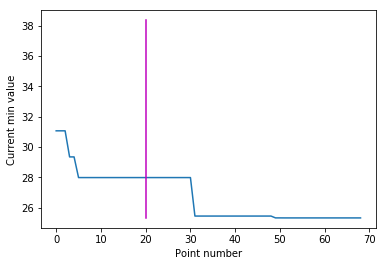

In [101]:
plt.plot([np.min(updated_values[:x]) for x in range(1, len(updated_values))])
plt.plot([initial_training_sample_size, initial_training_sample_size],  
            [np.min(updated_values), np.max(updated_values)], color='m')
plt.xlabel('Point number')
plt.ylabel('Current min value')

### Hyperparmeters tuning

* Almost all machine learning have hyperparameters
* Quality of the model depends on the hyperparameters
* Quality estimation for one set of hyperparameters can take long time
* => Bayesian optimization can be used for hyperparameters tuning.

#### Bayesian optimization for hyperparameter tuning

Objective function to optimize
* Takes hyperparameters as input
* Builds a model (maybe several times in case of cross-validation)
* Calculates and returns model quality

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from IPython import display

##### House pricing dataset

In this task you need to predict House Sale Price. There are 25 numerical input features like lot area, overall condition rating, house quality, number of kitchens and so on (there were a lot of categorical variables which we removed in this example for simplicity).

We are going to tune XGBoost parameters using Bayesian Optimization to obtain more accurate model.

In [104]:
data = np.loadtxt('house_pricing.csv')

X = data[:, :-1]
y = data[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

 C:\Users\User\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning:From version 0.21, test_size will always complement train_size unless both are specified.


We implement `model_error_cv()` function that will be our objective function.  
We are going to use RBF kernel in our Bayesian Optimization, the result of optimization will be continuous variables,
so we need to preprocess parameters - cast integer parameters to int.

In [105]:
def wrap_parameters(parameters, scaler=None):
    if scaler:
        parameters = scaler.transform(parameters)
    return parameters


def unwrap_parameters(parameters, scaler=None):
    if scaler:
        parameters = scaler.inverse_transform(parameters)
    p = [int(parameters[0]), parameters[1], int(parameters[2]),
         max(0, min(parameters[3], 1))]
    return p


def model_error_cv(parameters, X, y, scaler=None):
    errors = []
    for p in parameters:
        p = unwrap_parameters(p, scaler)
        model = xgboost.XGBRegressor(max_depth=p[0],
                                     learning_rate=p[1],
                                     n_estimators=p[2],
                                     subsample=p[3],
                                     )

        score = cross_val_score(model, X, y, cv=3).mean()
        errors.append(score)
    return np.array(errors).reshape(-1, 1)

We scale the parameters using StandardScaler() from sklearn - it is nice to have all the parameters with unit variance and mean zero
when using RBF kernel as it is easier to tune lengthscale parameters, because these parameters depend on the range of input variables.

In [108]:
# xgboost params: max_depth, learning_rate, n_estimators, subsample
lower_bound = np.array([1, 0.001, 100, 0.2]).reshape(1, -1)
upper_bound = np.array([6, 0.1, 1000, 1]).reshape(1, -1)

np.random.seed(42)
n_init_points = 10
initial_parameters = np.random.rand(n_init_points, len(lower_bound)) * (upper_bound - lower_bound) + lower_bound
initial_errors = -model_error_cv(initial_parameters, X, y)

scaler = StandardScaler()
scaler.fit(initial_parameters)
lower_bound = scaler.transform(lower_bound)
upper_bound = scaler.transform(upper_bound)
initial_parameters = wrap_parameters(initial_parameters, scaler)

It is also nice idea to explicitly constrain lengthscale parameter - it shouldn't be much larger than distance between points in the training set, it shouldn't be much smaller than the distance between points in the training set.

In [109]:
kernel = GPy.kern.RBF(len(lower_bound), lengthscale=(upper_bound - lower_bound).min() / n_init_points, ARD=False)
gp_model = GPy.models.GPRegression(initial_parameters, initial_errors, kernel=kernel)
gp_model.rbf.lengthscale.constrain_bounded(0.001, 10)
gp_model.optimize()
print(gp_model)
print(gp_model.rbf.lengthscale)


Name : GP regression
Objective : 3.8216262628900273
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |            value  |  constraints  |  priors
  rbf.variance             |   0.418120652234  |      +ve      |        
  rbf.lengthscale          |    2.31884566295  |  0.001,10.0   |        
  Gaussian_noise.variance  |  0.0635911154505  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     2.31884566  |  0.001,10.0   |        


 C:\Users\User\Anaconda2\envs\py36\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


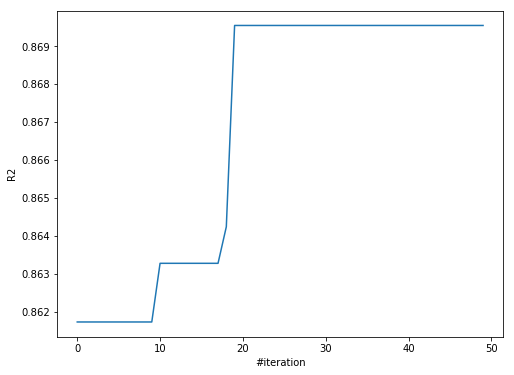

New parameters: [2, 0.0501270130052077, 979, 0.88071952156181876], new error:	0.8653525089786221
best parameters: [2, 0.039110388501199224, 799, 0.57794806529623188], best error:	0.8695530799939918
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.70482857  |  0.001,10.0   |        


In [111]:
budget = 40

hyperparameters = initial_parameters
errors = initial_errors
error_history = [-initial_errors[:i].min() for i in range(1, n_init_points + 1)]
objective = lambda x: -model_error_cv(x, X, y, scaler)
for i in range(budget):
    hyperparameters, errors, gp_model = bayes_opt.optimization_step(hyperparameters, errors, kernel, objective,
                                                                    lb=lower_bound, ub=upper_bound)
    error_history.append(-errors.min())
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.xlabel("#iteration")
    plt.ylabel("R2")
    plt.plot(error_history)
    plt.show()
    
    print("New parameters: {}, new error:\t{}\nbest parameters: {}, best error:\t{}".format(
        unwrap_parameters(hyperparameters[-1], scaler), -errors[-1, 0],
        unwrap_parameters(hyperparameters[errors.argmin()], scaler), -errors.min()))
    print(gp_model.rbf.lengthscale)